In [1]:
import csv
import datetime
import h5py
from sklearn.externals import joblib
import numpy as np
import os
import pandas as pd
import pickle
import sklearn.preprocessing
import sklearn.svm
import skm
import sys
import time

sys.path.append("../src")
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
patch_width = 32
n_patches_per_clip = 1
aug_str = "original"
instanced_aug_str = aug_str
log2Cs = range(-5, 15)


# Parse arguments.
args = ["unit01", "1"]
test_unit_str = args[0]
trial_id = int(args[1])


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Predicting SVM for " + dataset_name + " clips.")
print("Test unit: " + test_unit_str + ".")
print("Trial ID: " + str(trial_id) + ".")
print("")
print("h5py version: {:s}".format(h5py.__version__))
print("numpy version: {:s}".format(np.__version__))
print("scikit-learn version: {:s}".format(sklearn.__version__))
print("skm version: {:s}".format(skm.__version__))
print("")

2017-10-24 16:45:15.649495 Start.
Predicting SVM for BirdVox-70k clips.
Test unit: unit01.
Trial ID: 1.

h5py version: 2.6.0
numpy version: 1.13.1
scikit-learn version: 0.18.2
skm version: 0.0.1



In [2]:
# Retrieve fold such that test_unit_str is in the test set.
folds = localmodule.fold_units()
fold = [f for f in folds if test_unit_str in f[0]][0]
test_units = fold[0]
training_units = fold[1]
validation_units = fold[2]


# Define directory for trial.
models_dir = localmodule.get_models_dir()
skm_name = "skm-cv"
skm_dir = os.path.join(models_dir, skm_name)
unit_dir = os.path.join(skm_dir, test_unit_str)
trial_str = "trial-" + str(trial_id)
trial_dir = os.path.join(unit_dir, trial_str)


# Open CSV file for validation metrics.
val_metrics_name = "_".join([
    dataset_name,
    skm_name,
    test_unit_str,
    trial_str,
    "svm-model",
    "val-metrics.csv"])
val_metrics_path = os.path.join(
    trial_dir, val_metrics_name)
val_metrics_header = [
    "Dataset",
    "Test unit",
    "Trial ID",
    "log2(C)",
    "Validation accuracy (%)"
]


# Parse validation metrics as Pandas DataFrame.
val_df = pd.read_csv(
    val_metrics_path, header=None, names=val_metrics_header)


# Find C maximiwing validation accuracy.
log2Cs = np.array(val_df["log2(C)"])
val_accs = np.array(val_df["Validation accuracy (%)"])
best_val_accs = np.max(val_accs)
best_log2C = log2Cs[np.argmax(val_accs)]


# Print maximum validation accuracy and corresponding C.
print("Maximum validation accuracy: {:5.2f}% with log2(C) = {}".format(
    best_val_accs, best_log2C))


# Load SKM model.
skm_model_name = "_".join(
    [dataset_name,
     skm_name,
     test_unit_str,
     trial_str,
     "model.pkl"])
skm_model_path = os.path.join(
    trial_dir, skm_model_name)
with open(skm_model_path, 'rb') as skm_model_file:
    skm_model = pickle.load(skm_model_file)


# Load scaler.
scaler_name = "_".join(
    [dataset_name,
    skm_name,
    test_unit_str,
    trial_str,
    "scaler.pkl"])
scaler_path = os.path.join(trial_dir, scaler_name)
scaler = joblib.load(scaler_path)


# Load best SVM model.
if np.sign(best_log2C) >= 0:
    best_log2C_str = "+" + str(abs(best_log2C)).zfill(2)
else:
    best_log2C_str = "-" + str(abs(best_log2C)).zfill(2)
svm_model_name = "_".join(
    [dataset_name,
     "skm-cv",
     test_unit_str,
     trial_str,
     "svm-model",
     "log2C-(" + best_log2C_str + ").pkl"
    ])
svm_model_path = os.path.join(trial_dir, svm_model_name)
svm_model = joblib.load(svm_model_path)

Maximum validation accuracy: 78.35% with log2(C) = -5


In [28]:
"BirdVox-70k_skm-cv_unit01_trial-0_svm-model_val-metrics.csv"

'BirdVox-70k_skm-cv_unit01_trial-0_svm-model_val-metrics.csv'

In [108]:
# Define input folder.
aug_str = "original"
instanced_aug_str = aug_str
logmelspec_name = "_".join([dataset_name, "skm-logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
aug_dir = os.path.join(logmelspec_dir, aug_str)


# Initialize matrix of test data..
X_test = []
y_test = []


# Loop over test units.
for test_unit_str in test_units:

    # Load HDF5 container of logmelspecs.
    hdf5_name = "_".join([dataset_name, instanced_aug_str, test_unit_str])
    in_path = os.path.join(aug_dir, hdf5_name + ".hdf5")
    in_file = h5py.File(in_path)


    # List clips.
    clip_names = list(in_file["logmelspec"].keys())


    # Loop over clips.
    for clip_name in clip_names:
        # Read label.
        y_clip = int(clip_name.split("_")[3])

        # Load logmelspec.
        logmelspec = in_file["logmelspec"][clip_name].value

        # Load time-frequency patches.
        logmelspec_width = logmelspec.shape[1]
        logmelspec_mid = np.round(logmelspec_width * 0.5).astype('int')
        logmelspec_start = logmelspec_mid -\
            np.round(patch_width * n_patches_per_clip * 0.5).astype('int')

        # Extract patch.
        patch_start = logmelspec_start
        patch_stop = patch_start + patch_width
        patch = logmelspec[:, patch_start:patch_stop]

        # Append X and y.
        X_test.append(np.ravel(patch))
        y_test.append(y_clip)


# Concatenate raveled patches as rows and transpose.
X_test = np.stack(X_test)
y_test_true = np.stack(y_test)


# Transform test set.
X_test_skm = skm_model.transform(X_test.T).T


# Scale test data.
#X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_skm


# Compute predictions.
y_test_pred = svm_model.predict_proba(X_test_scaled)

In [109]:
y_test_pred

array([[  3.85987051e-08,   9.99999961e-01],
       [  1.28627231e-08,   9.99999987e-01],
       [  4.13125120e-07,   9.99999587e-01],
       ..., 
       [  4.82719752e-07,   9.99999517e-01],
       [  8.49393856e-07,   9.99999151e-01],
       [  1.06241938e-06,   9.99998938e-01]])

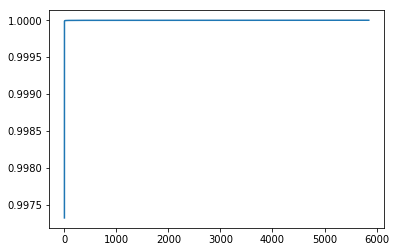

In [110]:
plt.plot(np.sort(y_test_pred[:, 1]))

In [105]:
Y_test_pred1e7 = (y_test_pred[:, 1] > 0.8)
sklearn.metrics.accuracy_score(y_test_true, Y_test_pred1e7)

0.93300884492594338

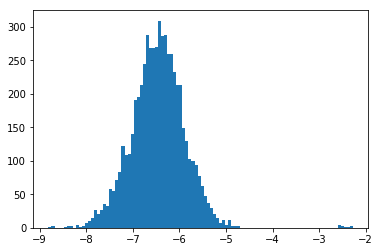

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(np.log10(1.0 - y_test_pred[:, 1]), bins=100);